In [6]:
import os
import pyautogui
from PIL import Image
import tkinter as tk
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pytesseract
import pandas as pd
from matplotlib.collections import PolyCollection
import re
import tkinter.filedialog as fd
import math
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinter import messagebox 

['Relative', 'True', 'GnBu', '0', None, 'X axis [cm]', 'Y axis [cm]', 'Thickness [nm]', '8439.742', '47.182']


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_5380\1762251195.py", line 537, in <lambda>
    command=lambda: [root.update(), frame2.update(), openNewWindow(root, frame2)])
  File "C:\Users\user\AppData\Local\Temp\ipykernel_5380\1762251195.py", line 455, in openNewWindow
    drawHeatmap(fileToDfs(imported), frame_fig)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_5380\1762251195.py", line 169, in fileToDfs
    return mergeDfs(df_imported)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_5380\1762251195.py", line 494, in mergeDfs
    return pd.concat([df for df in dfs])
  File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\reshape\concat.py", line 382, in concat
    op = _Concatenator(
  File "C:\Users\user\AppData\Local\Programs\Python\P

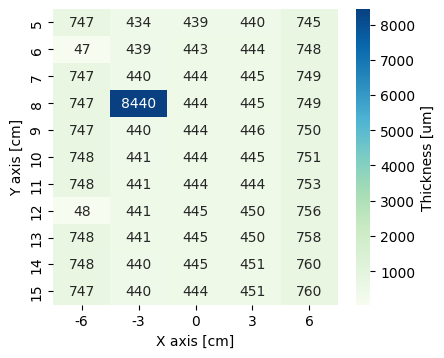

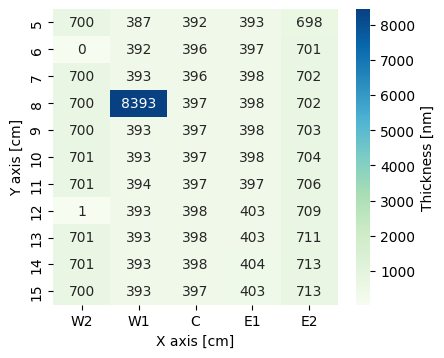

In [10]:
path = 'C:/Users/user/Desktop/Wet_Etching_Data'
today = str(dt.datetime.now()).split(' ')[0]
cust_parameters = []
df_fig = 0 # plt.figure object
v1, c2_options, c3_options, c4_entry, c5_entry, c6_entry, c7_entry, c8_entry, c9_entry = 0,0,0,0,0,0,0,0,0

try:
    os.mkdir(f'{path}/{today}') # to absolute path
except FileExistsError: # pass if the folder already exists
    pass
    
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
custom_config = r'--oem 3 --psm 6 outputbase digits'

def resizeFrame(event):
    if frame1 :
        frame1.place(x=40, rely=60/510, width=430, relheight=105/480)
        frame2.place(x=40, rely=1950/510, width=430, relheight=245/480)
        button1.place(relx=0.08, rely=0.01, relwidth=0.1, relheight=0.1)
        
def getTargetRegion(root, frame2):
    root_position = root.wm_geometry()
    x = int(root_position.split('+')[1])
    y = int(root_position.split('+')[2])
    # w = root.winfo_width()
    # h = root.winfo_height()
    frame_geo = frame2.winfo_geometry()
    x_f = int(frame_geo.split('+')[1])
    y_f = int(frame_geo.split('+')[2])
    w_f = frame2.winfo_width()
    h_f = frame2.winfo_height()
    return (x+x_f+8,y+y_f+31,w_f,h_f) # numbers 12 and 57 added to adjust a region of being captured

def readNumbers(img):
    # make an img larger to improve its accuracy
    (h, w) = img.shape[:2]
    new_width = 3000
    aspect_ratio = h / w
    new_height = int(new_width * aspect_ratio)
    img = cv2.resize(img, (new_width, new_height))
    # apply a threshold to increase accuracy
    _, binary = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY_INV) # comprise more pixels than before (200,255)
    numbers = pytesseract.image_to_string(binary, config=custom_config)
    numbers_list = numbers.split('\n')
    temp = []
    while '' in numbers_list:
        numbers_list.remove('') # remove the element resulted fom \n
    for i in numbers_list:
        temp_elem = i.split('.00')
        while '' in temp_elem:
            temp_elem.remove('')
        temp.append(temp_elem)
    return temp

def countDigit(n):
    return math.floor(math.log10(n)+1)
    
def fillRows(temp):  
    numbers_temp = []
    for row in temp:
        row_temp = []
        if len(row)!=5:
            for row_elem in row:
                if countDigit(int(row_elem)) <=6:
                    row_temp.append(row_elem)
                else:
                    row_temp.extend(row_elem.split('00', maxsplit=5-len(row)))
            numbers_temp.append(row_temp)
        else: 
            numbers_temp.append(row)
            
    for idx, row in enumerate(numbers_temp):
        numbers_temp[idx] = list(map(float, numbers_temp[idx]))
    
    return numbers_temp

def topNumbersToDf(numbers_list):
    rows = fillRows(numbers_list)
    df_top = pd.DataFrame(rows, columns=['W2','W1','C','E1','E2'])
    df_top['cm'] = [5+i for i in range(len(df_top))]
    df_top.set_index('cm', inplace=True)
    return df_top
    
def bottomNumbersToDf(numbers_list):
    rows = fillRows(numbers_list)
    df_bottom = pd.DataFrame(rows, columns=['E2','E1','C','W1','W2']) # inverse order
    df_bottom = df_bottom.iloc[::-1, ::-1] # reverse
    df_bottom['cm'] = [12+i for i in range(len(df_bottom))]
    df_bottom.set_index('cm', inplace=True)
    return df_bottom

def topPointNumbersToDf(numbers_list): # need to get position in cm
    rows = fillRows(numbers_list)
    df_top = pd.DataFrame(rows, columns=['W2','W1','C','E1','E2'])
    df_top = df_top.astype(float)
    return pd.concat([df_top, df_top.agg(['count', 'min', 'max', 'mean', 'std'])]).round(3)
    
def bottomPointNumbersToDf(numbers_list):
    rows = fillRows(numbers_list)
    df_bottom = pd.DataFrame(rows, columns=['E2','E1','C','W1','W2']) # inverse order
    df_bottom = df_bottom.iloc[::-1, ::-1] # reverse columns and rows 
    df_bottom = df_bottom.astype(float)
    return pd.concat([df_bottom, df_bottom.agg(['count', 'min', 'max', 'mean', 'std'])]).round(3)
        
def topMeasurement(root, frame, name):
    try:
        screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
        ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
        if name==None:
            name = '1_top'
        savePNG(root, frame2, name)
        df_top = topNumbersToDf(readNumbers(ss_gray))
        df_top.to_csv(f'{path}/{today}/{name}.csv', index=True)
        tk.messagebox.showinfo("Notification",  "SAVED") # popup notification
    except:
        tk.messagebox.showinfo("Notification",  "AN ERROR OCCURRED") # popup notification
            
def bottomMeasurement(root, frame, name):
    try:
        screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
        ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
        if name==None:
            name = '2_bottom'
        savePNG(root, frame2, name)
        # df_top = pd.read_csv(f'data/{today}/top.csv',index_col='cm')
        df_bottom = bottomNumbersToDf(readNumbers(ss_gray))
        df_bottom.to_csv(f'{path}/{today}/{name}.csv', index=True)
        tk.messagebox.showinfo("Notification",  "SAVED") # popup notification
    except:
        tk.messagebox.showinfo("Notification",  "AN ERROR OCCURRED") # popup notification

def getName(name):
    if name == '':
        return None
    else:
        return name

def pointMeasurement(roor, frame2, mode, name):
    if mode == 'Top':
        try:
            screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
            ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
            if name==None:
                name = '0_top_point'
            savePNG(root, frame2, name)
            df_top_point = topPointNumbersToDf(readNumbers(ss_gray))
            df_top_point.to_csv(f'{path}/{today}/{name}.csv', index=True)
            tk.messagebox.showinfo("Notification",  "SAVED") # popup notification
        except:
            tk.messagebox.showinfo("Notification",  "AN ERROR OCCURRED") # popup notification
    elif mode=='Bottom':
        try:
            screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
            ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
            if name==None:
                name = '0_bottom_point'
            savePNG(root, frame2, name)
            df_bottom_point = bottomPointNumbersToDf(readNumbers(ss_gray))
            df_bottom_point.to_csv(f'{path}/{today}/{name}.csv', index=True)
            tk.messagebox.showinfo("Notification",  "SAVED") # popup notification
        except:
            tk.messagebox.showinfo("Notification",  "AN ERROR OCCURRED") # popup notification
        
def fileToDfs(imported):
    df_imported = [pd.DataFrame(pd.read_csv(f'{path}/{i}', index_col='cm')) for i in imported]
    if len(df_imported)==1:
        return df_imported[0]
    else:
        return mergeDfs(df_imported)    
    
def drawHeatmap(df, frame_fig): # heatmap
    global df_fig
    
    fig, axs = plt.subplots()
    df = df / 1000
    sns.heatmap(df, annot=True, cmap=plt.cm.GnBu, fmt=".0f", xticklabels=range(-6,9,3), yticklabels=[int(i) for i in df.index], 
                    cbar_kws={'label':'Thickness [um]'})
    axs.set(xlabel='X axis [cm]', ylabel='Y axis [cm]')

    canvas = FigureCanvasTkAgg(fig,  frame_fig)
    canvas.draw()
    canvas.get_tk_widget().pack()
    df_fig = fig

def redrawHeatmap(frame_fig, df):
    global cust_parameters
    global df_fig
    
    # clear the plot frame
    for widget in frame_fig.winfo_children():
        widget.destroy()
    
    # values
    if cust_parameters[0] == 'Relative': # change df, else leave it as it is
        df = df - df.min().min()
    
    # params
    annot_bool = cust_parameters[1]
    color = cust_parameters[2]
    dc_point = cust_parameters[3]
    title = getName(cust_parameters[4])
    name_x = cust_parameters[5]
    name_y = cust_parameters[6]
    name_color = cust_parameters[7]
    minval = cust_parameters[8]
    maxval = cust_parameters[9]

    # type transformation
    if annot_bool == 'True':
        annot_bool = True
    else:
        annot_bool = False

    # color
    if color == 'GnBu':
        color = plt.cm.GnBu
    elif color == 'BuPu':
        color = plt.cm.BuPu
    elif color == 'RdPu':
        color = plt.cm.RdPu
    elif color == 'YlGn':
        color = plt.cm.YlGn
    elif color == 'PuBuGn':
        color = plt.cm.PuBuGn
    elif color == 'YlOrBr':
        color = plt.cm.YlOrBr

    df = df / 1000 # scaling
    fig, axs = plt.subplots()
    sns.heatmap(df, annot=annot_bool, cmap=color,  fmt=f'.{dc_point}f', cbar_kws={'label':name_color}, vmax=maxval, vmin=minval)
    if title != None:
        axs.set_title(title)
    axs.set(xlabel=name_x, ylabel=name_y)

    frame_fig.update()
    canvas = FigureCanvasTkAgg(fig, frame_fig) # new figure
    canvas.draw()
    canvas.get_tk_widget().pack()
    df_fig = fig
    
def open_file(n, frame_fig, label_imported):
    imported = []
    show_imported = []
    
    file = fd.askopenfilenames(parent=n, title='Select Files to Plot', initialdir=f'{path}/{today}')
    for i in n.splitlist(file):
       show_imported.append(i.split('/')[-1]) # for presentation
       imported.append(i.split('/')[-2]+'/'+i.split('/')[-1]) # file path
    label_imported.configure(text='Imported :'+''.join(map(lambda x: ' #'+ str(x),show_imported))) # list to string
    return imported
    
def changeConfig(n, frame_fig, df): # change heatmap parameters
    global cust_parameters
    c = tk.Tk()
    c.title('Plot Configuration')
    c.geometry('459x360+1000+580') # '459x360+1000+580'

    c_frame = tk.Frame(c, highlightbackground="black", highlightthickness=1)
    c_frame.place(relx=0.13, rely= 0.05, relheight=0.8, relwidth=0.74) #(x=40, y=60, width=430, height=105)

    # values
    c0 = tk.Label(c_frame, text = 'Values :')
    c0.grid(row = 0, column = 0, sticky = 'E', pady = 2)
    v0 = tk.StringVar(c_frame, "Absolute") 
    radio_a = tk.Radiobutton(c_frame, text = "Absolute", variable = v0, value = "Absolute")
    radio_r = tk.Radiobutton(c_frame, text = "Relative", variable = v0, value = "Relative")
    radio_a.grid(row=0, column=1, sticky = 'W', pady = 2)
    radio_r.grid(row=0, column=2, sticky = 'W', padx=3, pady = 2)

    # button to apply the setting
    c0_button = tk.Button(c_frame, text="Apply", font=('serif', 8, 'bold'), command=lambda: [c.update(), c_frame.update(), getMode(c, c_frame, v0.get(), df)])
    c0_button.grid(row=0, column=3, sticky = 'E', padx=2, pady = 2)
        
    # button
    bt_save_config = tk.Button(c, text="OK", font=('serif', 8, 'bold'), 
                    command=lambda: [c.update(), c_frame.update(),  n.update(), frame_fig.update(), 
                                     getParams([v0.get(), v1.get(), c2_options.get(), c3_options.get(), getName(c4_entry.get()), c5_entry.get(), 
                                                c6_entry.get(), c7_entry.get(), c8_entry.get(), c9_entry.get()]), 
                                     redrawHeatmap(frame_fig, df), c.destroy()])
    bt_save_config.place(relx=0.37, rely=0.88, relwidth=0.2, relheight=0.08)
    c.mainloop()

def getMode(c, c_frame, mode, df): # Absolute | Relative
    global cust_parameters
    global c7_entry, c8_entry, c9_entry
    if mode == 'Absolute':
        createCommonOptions(c, c_frame)

        c7 = tk.Label(c_frame, text="Colormap Label : ")
        c7.grid(row=7, column=0, sticky = 'E', pady = 2)
        c7_entry=tk.Entry(c_frame, width=13, insertontime=600)
        c7_entry.insert(0, 'Thickness [nm]')
        c7_entry.grid(row=7, column=1, sticky = 'E')
    
        # min, max values for colormap and ticks
        df_max = df.max().max() / 1000
        df_min = df.min().min() / 1000
        
        c8 = tk.Label(c_frame, text="Minimum Value : ")
        c8.grid(row=8, column=0, sticky = 'E', pady = 2)
        c8_entry=tk.Entry(c_frame, width=13, insertontime=600)
        c8_entry.insert(0, df_min)
        c8_entry.grid(row=8, column=1, sticky = 'E')
    
        c9 = tk.Label(c_frame, text="Maximum Value : ")
        c9.grid(row=9, column=0, sticky = 'E', pady = 2)
        c9_entry=tk.Entry(c_frame, width=13, insertontime=600)
        c9_entry.insert(0, df_max)
        c9_entry.grid(row=9, column=1, sticky = 'E')
        
    else: # relative
        createCommonOptions(c, c_frame)
        
        c7 = tk.Label(c_frame, text="Colormap Label : ")
        c7.grid(row=7, column=0, sticky = 'E', pady = 2)
        c7_entry=tk.Entry(c_frame, width=13, insertontime=600)
        c7_entry.insert(0, 'Relative Thickness [nm]')
        df_copy = df - df.min().min() # affects below
        c7_entry.grid(row=7, column=1, sticky = 'E')
    
        # min, max values for colormap and ticks
        df_max = df_copy.max().max() / 1000
        df_min = df_copy.min().min() / 1000

        c8 = tk.Label(c_frame, text="Minimum Value : ")
        c8.grid(row=8, column=0, sticky = 'E', pady = 2)
        c8_entry=tk.Entry(c_frame, width=13, insertontime=600)
        c8_entry.insert(0, df_min)
        c8_entry.grid(row=8, column=1, sticky = 'E')

        c9 = tk.Label(c_frame, text="Maximum Value : ")
        c9.grid(row=9, column=0, sticky = 'E', pady = 2)
        c9_entry=tk.Entry(c_frame, width=13, insertontime=600)
        c9_entry.insert(0, df_max)
        c9_entry.grid(row=9, column=1, sticky = 'E')

def createCommonOptions(c, c_frame):
    global v1, c2_options, c3_options, c4_entry, c5_entry, c6_entry
    if cust_parameters == []: # at first    
        # annotation
        c1 = tk.Label(c_frame, text = 'Annotation :')
        c1.grid(row=1, column =0, sticky = 'E', pady = 2)
        v1 = tk.StringVar(c_frame, "True") 
        radio_t = tk.Radiobutton(c_frame, text = "True", variable = v1, value = "True")
        radio_b = tk.Radiobutton(c_frame, text = "False", variable = v1, value = "False")
        radio_t.grid(row=1, column=1, sticky = 'W', pady = 2)
        radio_b.grid(row=1, column=2, sticky = 'W', pady = 2)
    
        # colormap
        c2 = tk.Label(c_frame, text = 'Colormap :')
        c2.grid(row=2, column=0, sticky = 'E', pady = 2)
        c2_options = tk.ttk.Combobox(c_frame, width = 10, textvariable = c2) 
        c2_options['values'] = ('GnBu','BuPu','RdPu','YlGn','BuGn','YlGnBu','PuBuGn','YlOrBr') 
        c2_options.grid(row=2, column=1, sticky = 'E') 
        c2_options.current(0)
    
        # decimal point
        c3 = tk.Label(c_frame, text = 'Decimal Point :')
        c3.grid(row=3, column=0, sticky = 'E', pady = 2)
        c3_options = tk.ttk.Combobox(c_frame, width = 10, textvariable = c3) 
        c3_options['values'] = ('0','1','2','3') 
        c3_options.grid(row=3, column=1, sticky = 'E') 
        c3_options.current(0)
    
        # title and x, y labels
        c4 = tk.Label(c_frame, text="Title : ")
        c4.grid(row=4, column=0, sticky = 'E', pady = 2)
        c4_entry=tk.Entry(c_frame, width=13, insertontime=600)
        c4_entry.insert(0, '')
        c4_entry.grid(row=4, column=1, sticky = 'E')
        
        c5 = tk.Label(c_frame, text="X Label : ")
        c5.grid(row=5, column=0, sticky = 'E', pady = 2)
        c5_entry=tk.Entry(c_frame, width=13, insertontime=600)
        c5_entry.insert(0, 'X axis [cm]')
        c5_entry.grid(row=5, column=1, sticky = 'E')
    
        c6 = tk.Label(c_frame, text="Y Label : ")
        c6.grid(row=6, column=0, sticky = 'E', pady = 2)
        c6_entry=tk.Entry(c_frame, width=13, insertontime=600)
        c6_entry.insert(0, 'Y axis [cm]')
        c6_entry.grid(row=6, column=1, sticky = 'E')
       
    else: # later
        # annotation
        c1 = tk.Label(c_frame, text = 'Annotation :')
        c1.grid(row=1, column =0, sticky = 'E', pady = 2)
        v1 = tk.StringVar(c_frame, cust_parameters[1])
        radio_t = tk.Radiobutton(c_frame, text = "True", variable = v1, value = "True")
        radio_b = tk.Radiobutton(c_frame, text = "False", variable = v1, value = "False")
        radio_t.grid(row=1, column=1, sticky = 'W', pady = 2)
        radio_b.grid(row=1, column=2, sticky = 'W', pady = 2)
    
        # colormap
        color_options = ['GnBu','BuPu','RdPu','YlGn','BuGn','YlGnBu','PuBuGn','YlOrBr']
        c2 = tk.Label(c_frame, text = 'Colormap :')
        c2.grid(row=2, column=0, sticky = 'E', pady = 2)
        c2_options = tk.ttk.Combobox(c_frame, width = 10, textvariable = c2) 
        c2_options['values'] = ('GnBu','BuPu','RdPu','YlGn','BuGn','YlGnBu','PuBuGn','YlOrBr') 
        c2_options.grid(row=2, column=1, sticky = 'E') 
        c2_options.current(color_options.index(cust_parameters[2]))
    
        # decimal point
        decimal_options = ['0','1','2','3']
        c3 = tk.Label(c_frame, text = 'Decimal Point :')
        c3.grid(row=3, column=0, sticky = 'E', pady = 2)
        c3_options = tk.ttk.Combobox(c_frame, width = 10, textvariable = c3) 
        c3_options['values'] = ('0','1','2','3') 
        c3_options.grid(row=3, column=1, sticky = 'E') 
        c3_options.current(decimal_options.index(cust_parameters[3]))
    
        # title and x, y labels
        c4 = tk.Label(c_frame, text="Title : ")
        c4.grid(row=4, column=0, sticky = 'E', pady = 2)
        c4_entry=tk.Entry(c_frame, width=13, insertontime=600)
        if cust_parameters[4]!=None:
            c4_entry.insert(0, cust_parameters[4])
        c4_entry.grid(row=4, column=1, sticky = 'E')
    
        c5 = tk.Label(c_frame, text="X Label : ")
        c5.grid(row=5, column=0, sticky = 'E', pady = 2)
        c5_entry=tk.Entry(c_frame, width=13, insertontime=600)
        c5_entry.insert(0, cust_parameters[5])
        c5_entry.grid(row=5, column=1, sticky = 'E')
    
        c6 = tk.Label(c_frame, text="Y Label : ")
        c6.grid(row=6, column=0, sticky = 'E', pady = 2)
        c6_entry=tk.Entry(c_frame, width=13, insertontime=600)
        c6_entry.insert(0, cust_parameters[6])
        c6_entry.grid(row=6, column=1, sticky = 'E')
    
def getParams(params):
    global cust_parameters
    cust_parameters = params
    print(cust_parameters)
    
def openNewWindow(root, frame2):
    global df_fig
    n = tk.Tk()
    n.title('Visualization of Wet Etching Rate')
    n.geometry('510x480+515+510') # positioned next to the main window
    
    # figure frame
    frame_fig = tk.Frame(n, bg='white') #, highlightbackground="black", highlightthickness=1
    frame_fig.place(relx=0.05, rely=0.1, relheight=0.8, relwidth=0.9)
    
    # Label 
    label_imported = tk.Label(n, text='') # font=('Arial', 11)
    label_imported.place(relx=0.05, rely=0.02, relheight=0.05) # right

    # automatically executed when this window is opened
    imported = open_file(n, frame_fig, label_imported)

    # defualt heatmap
    drawHeatmap(fileToDfs(imported), frame_fig)
    
    # configuration button
    bt_config = tk.Button(n, text="Configuration", command=lambda : [n.update(), frame_fig.update(), changeConfig(n, frame_fig, fileToDfs(imported))])
    bt_config.place(relx=0.75, rely=0.02, relheight=0.05, relwidth=0.2) # Right
        
    # save button at the bottom
    ll = tk.Label(n, text="File name : ")
    ll.place(relx=0.26, rely=470/510)
    entry=tk.Entry(n, width=11, insertontime=600)
    entry.grid(row=0, column=1)
    entry.place(relx=0.4, rely=470/510, height=20)
    button8 = tk.Button(n, text="Save Image", font=('serif', 8, 'bold'), 
                        command=lambda: [n.update(), frame_fig.update(), savePlot(n, frame_fig, getName(entry.get()), df_fig)])
    button8.place(relx=0.58, rely=470/510, relwidth=0.18, height=25)

    n.mainloop()    
    
def savePNG(root, frame, name): # get a file name as an input
    try:
        screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2)) # must concern the aread inside the transparent frame
        screenshot.save(f'{path}/{today}/{name}.PNG')
        tk.messagebox.showinfo("Notification",  "SAVED") # popup notification
    except:
        tk.messagebox.showinfo("Notification",  "AN ERROR OCCURRED") # popup notification

def savePlot(n, frame_fig, name, fig_obj):
    if name == None:
        name = '3_plot'
    try:
        fig_obj.savefig(f'{path}/{today}/{name}.PNG', bbox_inches='tight')
        tk.messagebox.showinfo("Notification",  "SAVED") # popup notification
    except:
        tk.messagebox.showinfo("Notification",  "AN ERROR OCCURRED") # popup notification

def mergeDfs(dfs):
    if len(dfs)>1:
        return pd.concat([df for df in dfs]).groupby('cm').mean()
    else:
        return pd.concat([df for df in dfs])
    
root = tk.Tk()
root.title("Measurement of Wet Etching Rate")
root.geometry('510x480+0+510')
root.wm_attributes('-transparentcolor', 'red')

# make this transparent frame adjustable
frame1 = tk.Frame(root, bg='red')
frame1.place(x=40, rely=60/480, width=430, relheight=105/510) #(x=40, y=60, width=430, height=105)

l = tk.Label(root, text = "W1      W2      C      E1      E2")
l.place(x=70, rely=175/510)
l.config(font =("Courier", 14))

frame2 = tk.Frame(root, bg='red')
frame2.place(x=40, rely=195/480, width=430, relheight=245/510) #(x=40, y=195, width=430, height=245)

# frame for buttons
fr=tk.Frame(root, background="red")
fr.grid(rowspan=1, columnspan=4)

#buttons 
v = tk.StringVar(root, "Top") 
# values = {"Top" : "Top", "Bottom" : "Bottom"}
radio_t = tk.Radiobutton(root, text = "Top", variable = v, value = "Top")
radio_b = tk.Radiobutton(root, text = "Bottom", variable = v, value = "Bottom")
radio_t.place(relx=0.185, rely=0.01, relwidth=0.1, relheight=0.05)
radio_b.place(relx=0.2, rely=0.06, relwidth=0.1, relheight=0.05)

button1 = tk.Button(root, text="Point", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update(), pointMeasurement(root, frame2, v.get(), getName(entry.get()))])
button1.place(relx=0.08, rely=0.01, relwidth=0.1, relheight=0.1)

button3 = tk.Button(root, text="Top", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update(), topMeasurement(root, frame2, getName(entry.get()))])
button3.place(relx=0.4, rely=0.01, relwidth=0.1, relheight=0.1)

button4 = tk.Button(root, text="Bottom", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update(), bottomMeasurement(root, frame2, getName(entry.get()))])
button4.place(relx=0.52, rely=0.01, relwidth=0.1, relheight=0.1)

button7 = tk.Button(root, text="Plot", font=('serif', 8, 'bold'), # open new windows
                    command=lambda: [root.update(), frame2.update(), openNewWindow(root, frame2)])
button7.place(relx=0.82, rely=0.01, relwidth=0.1, relheight=0.1)


# button at the bottom to save imgs
ll = tk.Label(root, text="File name : ")
ll.place(relx=0.26, rely=470/510)
entry=tk.Entry(root, width=11, insertontime=600)
entry.grid(row=0, column=1)
entry.place(relx=0.4, rely=470/510, height=20)
button8 = tk.Button(root, text="Save Image", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update(), savePNG(root, frame2, getName(entry.get()))])
button8.place(relx=0.58, rely=470/510, relwidth=0.18, height=25)

# root.bind('<Configure>', resizeFrame)
root.attributes('-topmost', True)
root.mainloop()